In [24]:
#we first import the libraries we will be using
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pathlib import Path
import seaborn as sns
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
days = 6

In [3]:
# Başlangıç saatini temsil eden değişken
begining = 9

# Bitiş saatini temsil eden değişken
ending = 22

# Her 15 dakika için oluşturulan liste
time_list = []

# Saat ve dakika formatı
saat_format = "{:02d}.{:02d}"

# Zaman listesini oluştur
for hour in range(begining, ending):
    for minu in range(0, 60, 15):
        time_list.append(saat_format.format(hour, minu))

In [4]:
D = []
for i in range(1,days+1):
    D.append(i)

DT = []
for i in D:
    for j in time_list:
        DT.append((i,j))
        
ID = []
for i in range(1,13):
    for d in D:
        ID.append((d,i))

In [5]:
#model
m = gp.Model("cfl")
m.ModelSense = GRB.MINIMIZE

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-03


In [6]:
# Daily cost of workers

c_part_time = 19000 / 24
c_full_time = 27000 / 24

#decision variables 
Pm_d = m.addVars(D,name="#ofPartTimeMorningWorker",vtype=GRB.INTEGER,obj=c_part_time,lb=0)
Pe_d = m.addVars(D,name="#ofPartTimeEveningWorker",vtype=GRB.INTEGER,obj=c_part_time,lb=0)
X_id = m.addVars(ID,name="#ofFullTimeWorker",vtype=GRB.INTEGER,obj=c_full_time,lb=0)


importing Jupyter notebook from HourlyForecast.ipynb


<string>:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2621
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -15882.234
Date:                Fri, 19 Jan 2024   AIC                          31768.468
Time:                        19:19:49   BIC                          31780.210
Sample:                             0   HQIC                         31772.721
                               - 2621                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2141      0.018     11.681      0.000       0.178       0.250
sigma2      1.079e+04    162.078     66.549      0.000    1.05e+04    1.11e+04
Ljung-Box (L1) (Q):                   0.01   Jarque-

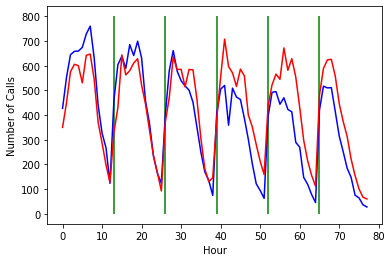

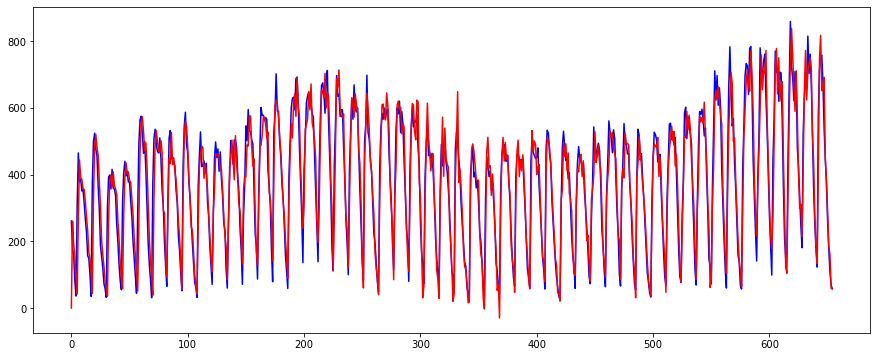

In [7]:
import import_ipynb
import HourlyForecast

In [8]:
import math

def erlang_c_formula(traffic_intensity, num_agents):
    """
    Erlang C Formula to calculate the probability of a call being in the queue.
    :param traffic_intensity: Traffic intensity (offered load) in erlangs
    :param num_agents: Number of agents in the call center
    :return: Probability of a call being in the queue
    """
    if traffic_intensity == 0:
        return 0
    elif num_agents == traffic_intensity:
        return 1
    else:
        term1 = ((traffic_intensity ** num_agents) / math.factorial(num_agents))*(num_agents / (num_agents - traffic_intensity))
        #print(traffic_intensity)
        term2 = sum([(traffic_intensity ** i) / math.factorial(i) for i in range(num_agents)])
        return term1 / (term2 + term1)

def calculate_agents_for_service_level(service_level_target, total_calls_per_hour, average_call_duration):
    """
    Calculate the number of agents needed to achieve a certain service level.
    :param service_level_target: Target service level (e.g., 95%)
    :param total_calls_per_hour: Total incoming calls per hour
    :param average_call_duration: Average duration of a call in seconds
    :return: Number of agents needed
    """
    traffic_intensity = (total_calls_per_hour * average_call_duration) / 3600  # convert seconds to hours
    num_agents = 1

    while erlang_c_formula(traffic_intensity, num_agents) > (1 - service_level_target):
        num_agents += 1

    return num_agents

# Example usage:
service_level_target = 0.95  # 95%
# total_calls_per_hour = 500  # replace with your desired total incoming calls per hour
average_call_duration = HourlyForecast.ortalama_AHT * 1.2  # 172.32462643678159 * 1.2 seconds

# num_agents_needed = calculate_agents_for_service_level(service_level_target, total_calls_per_hour, average_call_duration)
#print(f"Number of agents needed to achieve a {service_level_target * 100}% service level: {num_agents_needed}")


In [9]:
populated_forcast = []
for i in HourlyForecast.forecastx:
    for j in range(4):
        populated_forcast.append(i)
        
#print(populated_forcast)
data = {}
for i in range(len(DT)):
    data[DT[i]] = calculate_agents_for_service_level(service_level_target, populated_forcast[i], average_call_duration)
    

In [10]:
#data

In [11]:
con1 = m.addConstrs(
    (data[(d,"09.00")] <= Pm_d[d] + X_id[(d,1)]  for d in D ),"Interval_1")

con2 = m.addConstrs(
    (data[(d,"09.15")] <= Pm_d[d] + X_id[(d,1)] +  X_id[(d,2)]  for d in D ),"Interval_2")


con3 = m.addConstrs(
    (data[(d,"09.30")] <= Pm_d[d] + X_id[(d,1)] +  X_id[(d,2)] +  X_id[(d,3)]  for d in D ),"Interval_3")

con4 = m.addConstrs(
    (data[(d,"09.45")] <= Pm_d[d] + sum(X_id[(d, t)] for t in range(1,5))  for d in D ),"Interval_4")


con5 = m.addConstrs(
    (data[(d,"10.00")] <= Pm_d[d] + sum(X_id[(d, t)] for t in range(1,6))  for d in D ),"Interval_5")

con6 = m.addConstrs(
    (data[(d,"10.15")] <= Pm_d[d] + sum(X_id[(d, t)] for t in range(1,7))  for d in D ),"Interval_6")

con7 = m.addConstrs(
    (data[(d,"10.30")] <= Pm_d[d] + sum(X_id[(d, t)] for t in range(1,7))  for d in D ),"Interval_7")

con8 = m.addConstrs(
    (data[(d,"10.45")] <= Pm_d[d] + sum(X_id[(d, t)] for t in range(1,8))  for d in D ),"Interval_8")

con9 = m.addConstrs(
    (data[(d,"11.00")] <= Pm_d[d] + sum(X_id[(d, t)] for t in range(1,8))  for d in D ),"Interval_9")

con10 = m.addConstrs(
    (data[(d,"11.15")] <= Pm_d[d] + sum(X_id[(d, t)] for t in range(1,9))  for d in D ),"Interval_10")

con11 = m.addConstrs(
    (data[(d,"11.30")] <= Pm_d[d] + sum(X_id[(d, t)] for t in range(1,10))  for d in D ),"Interval_11")

con12 = m.addConstrs(
    (data[(d,"11.45")] <= Pm_d[d] + sum(X_id[(d, t)] for t in range(1,11))  for d in D ),"Interval_12")

con13 = m.addConstrs(
    (data[(d,"12.00")] <= Pm_d[d] + sum(X_id[(d, t)] for t in range(1,11))  for d in D ),"Interval_13")

con14 = m.addConstrs(
    (data[(d,"12.15")] <= Pm_d[d] + sum(X_id[(d, t)] for t in range(1,12))  for d in D ),"Interval_14")

con15 = m.addConstrs(
    (data[(d,"12.30")] <= Pm_d[d] + sum(X_id[(d, t)] for t in range(1,13))  for d in D ),"Interval_15")

con16 = m.addConstrs(
    (data[(d,"12.45")] <= Pm_d[d] + sum(X_id[(d, t)] for t in range(1,13))  for d in D ),"Interval_16")

con17 = m.addConstrs(
    (data[(d,"13.00")] <=  Pm_d[d] + sum(X_id[(d, t)] for t in range(1,13))  for d in D ),"Interval_17")

con18 = m.addConstrs(
    (data[(d,"13.15")] <=  Pm_d[d] + sum(X_id[(d, t)] for t in range(1,13))  for d in D ),"Interval_18")

con19 = m.addConstrs(
    (data[(d,"13.30")] <=  Pm_d[d] + sum(X_id[(d, t)] for t in range(1,13))  for d in D ),"Interval_19")

con20 = m.addConstrs(
    (data[(d,"13.45")] <=  sum(X_id[(d, t)] for t in range(1,13))  for d in D ),"Interval_20")

con21 = m.addConstrs(
    (data[(d,"14.00")] <=  sum(X_id[(d, t)] for t in range(1,13))  for d in D ),"Interval_21")

con22 = m.addConstrs(
    (data[(d,"14.15")] <=  sum(X_id[(d, t)] for t in range(1,13))  for d in D ),"Interval_22")

con23 = m.addConstrs(
    (data[(d,"14.30")] <=  sum(X_id[(d, t)] for t in range(1,13))  for d in D ),"Interval_23")

con24 = m.addConstrs(
    (data[(d,"14.45")] <=  sum(X_id[(d, t)] for t in range(1,13))  for d in D ),"Interval_24")

con25 = m.addConstrs(
    (data[(d,"15.00")] <=  sum(X_id[(d, t)] for t in range(1,13))  for d in D ),"Interval_25")

con26 = m.addConstrs(
    (data[(d,"15.15")] <=  sum(X_id[(d, t)] for t in range(1,13))  for d in D ),"Interval_26")

con27 = m.addConstrs(
    (data[(d, "15.30")] <= sum(X_id[(d, t)] for t in range(1, 13)) for d in D), "Interval_27")

con28 = m.addConstrs(
    (data[(d, "15.45")] <= sum(X_id[(d, t)] for t in range(1, 13)) for d in D), "Interval_28")

con29 = m.addConstrs(
    (data[(d, "16.00")] <= sum(X_id[(d, t)] for t in range(1, 13)) for d in D), "Interval_29")

con30 = m.addConstrs(
    (data[(d, "16.15")] <= sum(X_id[(d, t)] for t in range(1, 13)) for d in D), "Interval_30")

con31 = m.addConstrs(
    (data[(d, "16.30")] <= sum(X_id[(d, t)] for t in range(1, 13)) for d in D), "Interval_31")

con32 = m.addConstrs(
    (data[(d, "16.45")] <= sum(X_id[(d, t)] for t in range(1, 13)) for d in D), "Interval_32")

con33 = m.addConstrs(
    (data[(d, "17.00")] <= Pe_d[d] + sum(X_id[(d, t)] for t in range(1, 13)) for d in D), "Interval_33")

con34 = m.addConstrs(
    (data[(d, "17.15")] <= Pe_d[d] + sum(X_id[(d, t)] for t in range(1, 13)) for d in D), "Interval_34")

con35 = m.addConstrs(
    (data[(d, "17.30")] <= Pe_d[d] + sum(X_id[(d, t)] for t in range(1, 13)) for d in D), "Interval_35")

con36 = m.addConstrs(
    (data[(d, "17.45")] <= Pe_d[d] + sum(X_id[(d, t)] for t in range(1, 13)) for d in D), "Interval_36")

con37 = m.addConstrs(
    (data[(d, "18.00")] <= Pe_d[d] + sum(X_id[(d, t)] for t in range(1, 13)) for d in D), "Interval_37")

con38 = m.addConstrs(
    (data[(d, "18.15")] <= Pe_d[d] + sum(X_id[(d, t)] for t in range(1, 13)) for d in D), "Interval_38")

con39 = m.addConstrs(
    (data[(d, "18.30")] <= Pe_d[d] + sum(X_id[(d, t)] for t in range(2, 13)) for d in D), "Interval_39")

con40 = m.addConstrs(
    (data[(d, "18.45")] <= Pe_d[d] + sum(X_id[(d, t)] for t in range(3, 13)) for d in D), "Interval_40")

con41 = m.addConstrs(
    (data[(d, "19.00")] <= Pe_d[d] + sum(X_id[(d, t)] for t in range(4, 13)) for d in D), "Interval_41")

con42 = m.addConstrs(
    (data[(d, "19.15")] <= Pe_d[d] + sum(X_id[(d, t)] for t in range(5, 13)) for d in D), "Interval_42")

con43 = m.addConstrs(
    (data[(d, "19.30")] <= Pe_d[d] + sum(X_id[(d, t)] for t in range(6, 13)) for d in D), "Interval_43")

con44 = m.addConstrs(
    (data[(d, "19.45")] <= Pe_d[d] + sum(X_id[(d, t)] for t in range(7, 13)) for d in D), "Interval_44")

con45 = m.addConstrs(
    (data[(d, "20.00")] <= Pe_d[d] + sum(X_id[(d, t)] for t in range(7, 13)) for d in D), "Interval_45")

con46 = m.addConstrs(
    (data[(d, "20.15")] <= Pe_d[d] + sum(X_id[(d, t)] for t in range(8, 13)) for d in D), "Interval_46")

con47 = m.addConstrs(
    (data[(d, "20.30")] <= Pe_d[d] + sum(X_id[(d, t)] for t in range(8, 13)) for d in D), "Interval_47")

con48 = m.addConstrs(
    (data[(d, "20.45")] <= Pe_d[d] + sum(X_id[(d, t)] for t in range(9, 13)) for d in D), "Interval_48")

con49 = m.addConstrs(
    (data[(d, "21.00")] <= Pe_d[d] + sum(X_id[(d, t)] for t in range(10, 13)) for d in D), "Interval_49")

con50 = m.addConstrs(
    (data[(d, "21.15")] <= Pe_d[d] + sum(X_id[(d, t)] for t in range(11, 13)) for d in D), "Interval_50")

con51 = m.addConstrs(
    (data[(d, "21.30")] <= Pe_d[d] + sum(X_id[(d, t)] for t in range(11, 13)) for d in D), "Interval_51")

con52 = m.addConstrs(
    (data[(d, "21.45")] <=  X_id[(d, 12)]  for d in D), "Interval_52")

In [12]:
#now we solve our model
m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[x86])
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 312 rows, 84 columns and 2964 nonzeros
Model fingerprint: 0x20fc8c86
Variable types: 0 continuous, 84 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e+02, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 5e+01]
Found heuristic solution: objective 427500.00000
Presolve removed 304 rows and 78 columns
Presolve time: 0.01s
Presolved: 8 rows, 6 columns, 27 nonzeros
Found heuristic solution: objective 396500.00000
Variable types: 0 continuous, 6 integer (0 binary)
Found heuristic solution: objective 396166.66667

Root relaxation: objective 3.941667e+05, 6 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0        

In [13]:
m.printStats()


Statistics for modelcfl:
  Linear constraint matrix    : 312 Constrs, 84 Vars, 2964 NZs
  Variable types              : 0 Continuous,
84 Integer
  Matrix coefficient range    : [ 1, 1 ]
  Objective coefficient range : [ 791.667, 1125 ]
  Variable bound range        : [ 0, 0 ]
  RHS coefficient range       : [ 8, 53 ]


In [14]:
#Weekly Cost
print("Total Cost:" ,m.getObjective().getValue() )

Total Cost: 394166.6666666667


# Weekly Shift Plan:

In [15]:
m.printAttr("x")


    Variable            x 
-------------------------
#ofPartTimeMorningWorker[1]           13 
#ofPartTimeMorningWorker[2]           12 
#ofPartTimeMorningWorker[3]           18 
#ofPartTimeMorningWorker[4]           24 
#ofPartTimeMorningWorker[5]            8 
#ofPartTimeMorningWorker[6]           12 
#ofPartTimeEveningWorker[2]            5 
#ofPartTimeEveningWorker[4]            4 
#ofPartTimeEveningWorker[5]            3 
#ofPartTimeEveningWorker[6]            1 
#ofFullTimeWorker[1,1]           18 
#ofFullTimeWorker[2,1]           25 
#ofFullTimeWorker[3,1]           19 
#ofFullTimeWorker[4,1]           20 
#ofFullTimeWorker[5,1]           27 
#ofFullTimeWorker[6,1]           29 
#ofFullTimeWorker[1,3]            6 
#ofFullTimeWorker[2,3]            7 
#ofFullTimeWorker[3,3]            9 
#ofFullTimeWorker[4,3]            5 
#ofFullTimeWorker[5,3]            6 
#ofFullTimeWorker[6,3]            4 
#ofFullTimeWorker[1,7]            7 
#ofFullTimeWorker[2,7]            5 
#ofFullT

In [16]:
for d in D:
    if Pm_d[d].X>0:
        print("Pm_%g = %g" % (d,Pm_d[d].X) )     

Pm_1 = 13
Pm_2 = 12
Pm_3 = 18
Pm_4 = 24
Pm_5 = 8
Pm_6 = 12


In [17]:
        
for d in D:
    if Pe_d[d].X>0:
        print("Pe_%g = %g" % (d,Pe_d[d].X) )
        


Pe_2 = 5
Pe_4 = 4
Pe_5 = 3
Pe_6 = 1


In [18]:
for d,i in ID:
    if X_id[d,i].X>0:
        print("X day: %g section:%g = %g" % (d,i,X_id[d,i].X))


X day: 1 section:1 = 18
X day: 2 section:1 = 25
X day: 3 section:1 = 19
X day: 4 section:1 = 20
X day: 5 section:1 = 27
X day: 6 section:1 = 29
X day: 1 section:3 = 6
X day: 2 section:3 = 7
X day: 3 section:3 = 9
X day: 4 section:3 = 5
X day: 5 section:3 = 6
X day: 6 section:3 = 4
X day: 1 section:7 = 7
X day: 2 section:7 = 5
X day: 3 section:7 = 2
X day: 4 section:7 = 4
X day: 5 section:7 = 5
X day: 6 section:7 = 2
X day: 1 section:9 = 5
X day: 1 section:12 = 13
X day: 2 section:12 = 11
X day: 3 section:12 = 15
X day: 4 section:12 = 16
X day: 5 section:12 = 12
X day: 6 section:12 = 8


The number of people required to work in every 15-minute interval found by Lp for the week given in the forecast:

In [19]:
full_result =  {1 : [], 2 : [], 3 : [], 4 : [], 5 : [], 6 : []}
con = m.getConstrs()
for i in range(len(con)):
    for j in range(6):
        if i % 6 == j:
            rhs = m.getRow(con[i]).getValue()
            full_result[j+1].append(rhs)
            
full_result

{1: [31.0,
  31.0,
  37.0,
  37.0,
  37.0,
  37.0,
  37.0,
  44.0,
  44.0,
  44.0,
  49.0,
  49.0,
  49.0,
  49.0,
  62.0,
  62.0,
  62.0,
  62.0,
  62.0,
  49.0,
  49.0,
  49.0,
  49.0,
  49.0,
  49.0,
  49.0,
  49.0,
  49.0,
  49.0,
  49.0,
  49.0,
  49.0,
  49.0,
  49.0,
  49.0,
  49.0,
  49.0,
  49.0,
  31.0,
  31.0,
  25.0,
  25.0,
  25.0,
  25.0,
  25.0,
  18.0,
  18.0,
  18.0,
  13.0,
  13.0,
  13.0,
  13.0],
 2: [37.0,
  37.0,
  44.0,
  44.0,
  44.0,
  44.0,
  44.0,
  49.0,
  49.0,
  49.0,
  49.0,
  49.0,
  49.0,
  49.0,
  60.0,
  60.0,
  60.0,
  60.0,
  60.0,
  48.0,
  48.0,
  48.0,
  48.0,
  48.0,
  48.0,
  48.0,
  48.0,
  48.0,
  48.0,
  48.0,
  48.0,
  48.0,
  53.0,
  53.0,
  53.0,
  53.0,
  53.0,
  53.0,
  28.0,
  28.0,
  21.0,
  21.0,
  21.0,
  21.0,
  21.0,
  16.0,
  16.0,
  16.0,
  16.0,
  16.0,
  16.0,
  11.0],
 3: [37.0,
  37.0,
  46.0,
  46.0,
  46.0,
  46.0,
  46.0,
  48.0,
  48.0,
  48.0,
  48.0,
  48.0,
  48.0,
  48.0,
  63.0,
  63.0,
  63.0,
  63.0,
  63.0,
  45.

In [20]:
result = []
con = m.getConstrs()
for i in range(len(con)):
    if i % 6 == 2:
        rhs = m.getRow(con[i]).getValue()
        result.append(rhs)
        
        
#result

In [21]:
hourly_result = []
for i in range(len(result)//4):
    AnHour = result[i*4]/4 + result[i*4+1]/4 + result[i*4+2]/4 + result[i*4+3]/4
    hourly_result.append(round(AnHour))
    
#hourly_result

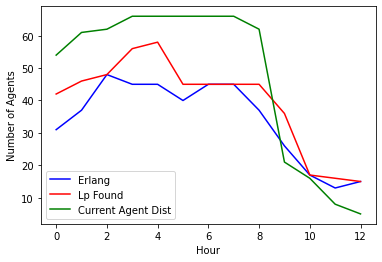

In [22]:
#An Example Graph For A Day

third_day = []
for i in data:
    if i[0] == 3:
        third_day.append(data[i])
        
third_day_clean = []        
for i in range(len(third_day)//4):
    third_day_clean.append(third_day[i*4])
    
company_third_day = [54, 61, 62, 66, 66, 66, 66, 66, 62, 21, 16, 8, 5]

plt.plot(third_day_clean, color='b', label='Erlang')
plt.plot(hourly_result, color='r', label='Lp Found')
plt.plot(company_third_day, color='g', label='Current Agent Dist')

# Adding axis labels
plt.xlabel('Hour')
plt.ylabel('Number of Agents')

# Displaying the legend
plt.legend()

# Show the plot
plt.show()

In [23]:
m.write("model.lp")